In [102]:
#@title Imports
from tensorflow import keras
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from google.colab import drive

from sklearn.utils import resample
from scipy import stats

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
tf.random.set_seed(42)

In [103]:
#@title Model
def build_resnet(input_shape, nb_classes, n_feature_maps = 64):
    x = layers.Input(shape=(input_shape))
    conv_x = layers.BatchNormalization()(x)
    conv_x = layers.Conv2D(n_feature_maps, 8, 1, padding='same')(conv_x)
    conv_x = layers.BatchNormalization()(conv_x)
    conv_x = layers.Activation('relu')(conv_x)
     
    conv_y = layers.Conv2D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = layers.BatchNormalization()(conv_y)
    conv_y = layers.Activation('relu')(conv_y)
     
    conv_z = layers.Conv2D(n_feature_maps, 3, 1, padding='same')(conv_y)
    conv_z = layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = layers.Conv2D(n_feature_maps, 1, 1,padding='same')(x)
        shortcut_y = layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = ker.layers.BatchNormalization()(x)

    y = layers.Add()([shortcut_y, conv_z])
    y = layers.Activation('relu')(y)
     
    x1 = y
    conv_x = layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = layers.BatchNormalization()(conv_x)
    conv_x = layers.Activation('relu')(conv_x)
     
    conv_y = layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = layers.BatchNormalization()(conv_y)
    conv_y = layers.Activation('relu')(conv_y)
     
    conv_z = layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = layers.BatchNormalization()(x1)

    y = layers.Add()([shortcut_y, conv_z])
    y = layers.Activation('relu')(y)
     
    x1 = y
    conv_x = layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = layers.BatchNormalization()(conv_x)
    conv_x = layers.Activation('relu')(conv_x)
     
    conv_y = layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = layers.BatchNormalization()(conv_y)
    conv_y = layers.Activation('relu')(conv_y)
     
    conv_z = layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = layers.BatchNormalization()(x1)

    y = layers.Add()([shortcut_y, conv_z])
    y = layers.Activation('relu')(y)
     
    full = layers.GlobalAveragePooling2D()(y)
    out = layers.Dense(nb_classes, activation='softmax')(full)

    return x, out

In [104]:
#@title Data download
drive.mount('/content/drive/')

!cp "/content/drive/MyDrive/boiled_data.csv" "/home/"
df = pd.read_csv('/home/boiled_data.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [105]:
#@title Downsampling
df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]
 
df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

11    30720
10    30720
9     30720
5     30720
4     30720
3     30720
2     30720
1     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [106]:
df1 = df.copy()

for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)

In [107]:
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

In [108]:
train = df1[(df1['subject'] != 'subject9') & (df1['subject'] != 'subject10')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape

((266295, 8), (69386, 8))

In [109]:
X_train = train.drop(['Activity', 'subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity', 'subject'],axis=1)
y_test = test['Activity']

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((266295, 6), (266295,), (69386, 6), (69386,))

In [110]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])

    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [111]:
X_train,y_train = create_dataset(X_train, y_train, 100, step=50)
X_test,y_test = create_dataset(X_test, y_test, 100, step=50)

X_train.shape, y_train.shape

((5324, 100, 6), (5324, 1))

In [112]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [113]:
callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/modelDL.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]

nb_classes = len(label_map)

x , y = build_resnet(X_train.shape[1:], nb_classes)
model = keras.models.Model(inputs=x, outputs=y)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)

In [114]:
model_history = model.fit(X_train, y_train, epochs= 1000, validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/1000
167/167 [==============================] - 33s 176ms/step - loss: 1.1072 - sparse_categorical_accuracy: 0.6214 - val_loss: 7.7801 - val_sparse_categorical_accuracy: 0.3391


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/1000
167/167 [==============================] - 28s 168ms/step - loss: 0.3437 - sparse_categorical_accuracy: 0.8865 - val_loss: 1.2002 - val_sparse_categorical_accuracy: 0.7338
Epoch 3/1000
167/167 [==============================] - 29s 171ms/step - loss: 0.2374 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.4344 - val_sparse_categorical_accuracy: 0.8463
Epoch 4/1000
167/167 [==============================] - 28s 170ms/step - loss: 0.1825 - sparse_categorical_accuracy: 0.9389 - val_loss: 1.1665 - val_sparse_categorical_accuracy: 0.8297
Epoch 5/1000
167/167 [==============================] - 29s 172ms/step - loss: 0.1408 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.2186 - val_sparse_categorical_accuracy: 0.9127
Epoch 6/1000
167/167 [==============================] - 28s 170ms/step - loss: 0.0993 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.2244 - val_sparse_categorical_accuracy: 0.9235
Epoch 7/1000
167/167 [==============================] - 28s 170ms/step - lo

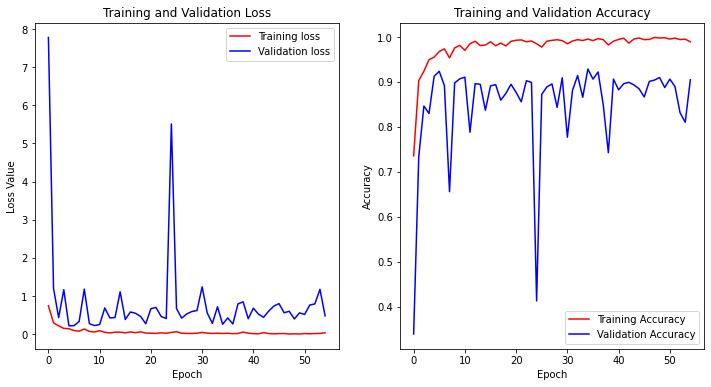

In [115]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [116]:
model = keras.models.load_model('/content/drive/MyDrive/modelDL.h5')

train_loss, train_acc = model.evaluate(X_train,y_train)
test_loss, test_acc = model.evaluate(X_test,y_test)

print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

44/44 [==============================] - 2s 42ms/step - loss: 0.2186 - sparse_categorical_accuracy: 0.9127
Train accuracy 95.17 %
Train loss 0.1315745711326599
Test accuracy 91.27 %
Test loss 0.21862006187438965


In [117]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
pred = pred.reshape(-1,1)

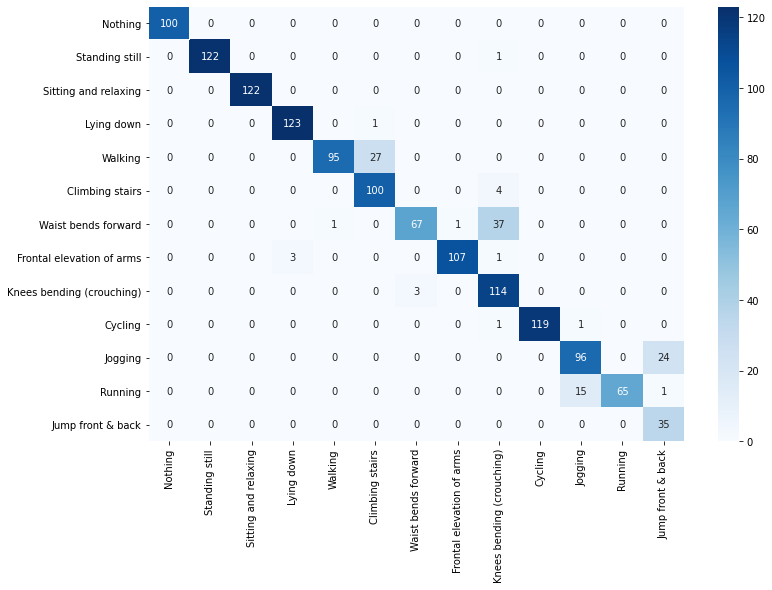

In [118]:
plt.figure(figsize=(12,8))
conf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(conf_matrix, xticklabels= label_map.values(), yticklabels= label_map.values(), annot=True, fmt="d", cmap="Blues")
plt.show()